In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

markersize 

In [67]:
df = pd.read_csv("../k2scoc/results/tables/full_table.csv")
df.shape

(6254, 24)

In [68]:
hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0) & (df.todrop.isnull()) & (df.cstart.isnull())
df = df[hasflares  | wassearched]

In [69]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
tobs = df[["LC_time_years","EPIC","C"]].drop_duplicates().LC_time_years.sum()

In [70]:
tobs

324.09599589322386

In [71]:
df.shape

(3707, 25)

## Full sample FFD


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Fitted power law alpha=1.9530919526581072
Fitted power law beta=936.3905994904347


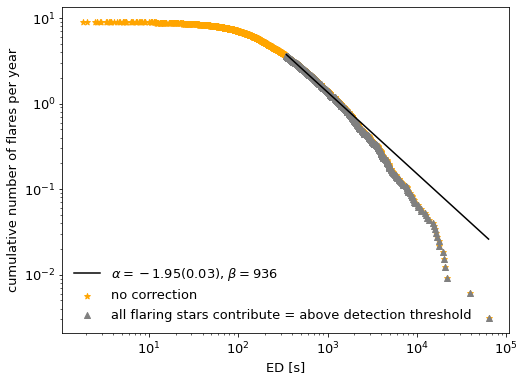

In [72]:
fig, ax =  plt.subplots(1, figsize=(8,6))
ffd = FFD(f=df[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*", label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

alpha, alpha_err = ffd.fit_powerlaw()
print(f"Fitted power law alpha={ffd.alpha}")

#ffd.alpha, ffd.alpha_err = 2., .2

betas, beta, beta_err = ffd.fit_beta_to_powerlaw()
print(f"Fitted power law beta={ffd.beta}")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()


ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey", label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", label=fr"$\alpha=-${ffd.alpha:.2f}({ffd.alpha_err:.2f}), $\beta=${int(np.rint(ffd.beta))}")

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per year")

plt.savefig(f"plots/{tstamp}_full_sample_ffd.png", dpi=300)

In [57]:
ispowerlaw, truncated

(False, True)

In [58]:
ffd.alpha_err

0.03047495822454131

## Teff bins


In [73]:
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates()
bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T

,Teff_median,cluster,LC_time_years
0,2500-3000,hyades,2.993326
1,2500-3000,ngc2682,NaN
2,2500-3000,ngc6774,NaN
3,2500-3000,pleiades,9.360027
4,2500-3000,praesepe,2.125998
5,3000-3250,hyades,10.267910
6,3000-3250,ngc2682,NaN
7,3000-3250,ngc6774,NaN
8,3000-3250,pleiades,56.475645
9,3000-3250,praesepe,51.567933


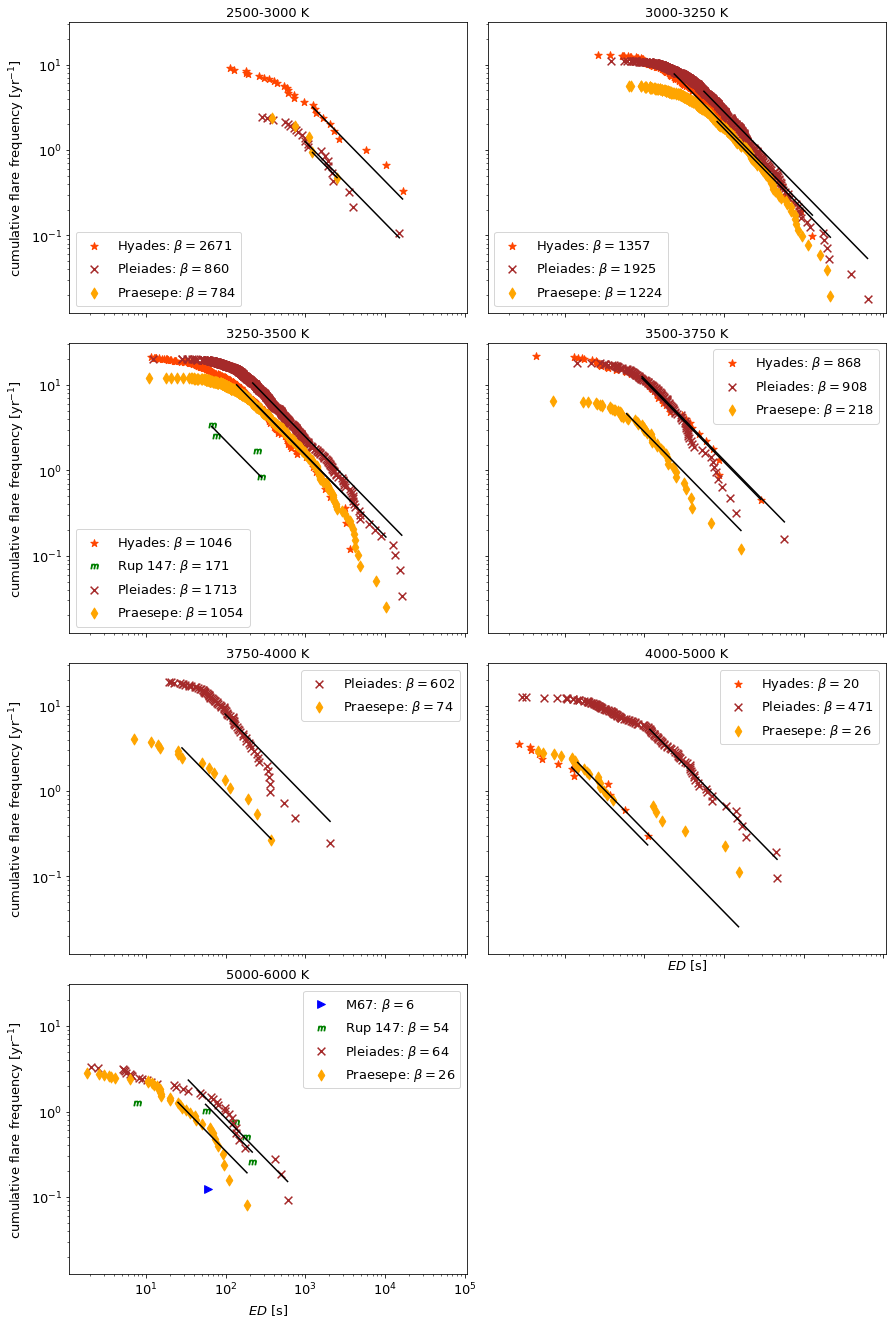

In [74]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))

resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), sharex=True, sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    resed[i]={}
    for j, h in g.groupby("cluster"):

       # print(i,j)
       # print(h.shape)
        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha, ffd.alpha_err = alpha, alpha_err

            betas, beta, beta_err = ffd.fit_beta_to_powerlaw()
           # print(f"Fitted power law beta={ffd.beta}")
            if j == "ngc2682":
                E, y = ffd.ed[0], ffd.freq[0]
                ffd.beta = y * np.power(E, ffd.alpha-1)
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
                
            else:
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"beta":ffd.beta,
                                "beta_err":ffd.beta_err,
                                "nflares":len(ed),
                                "age":ccol[j][3],
                                "age_uperr":ccol[j][4],
                                "age_lowerr":ccol[j][5]
                                }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\beta=${int(np.rint(ffd.beta))}")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].legend()

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")
for i in [5,6]:
    axes[i].set_xlabel(r"$ED$ [s]")
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED.png", dpi=300)

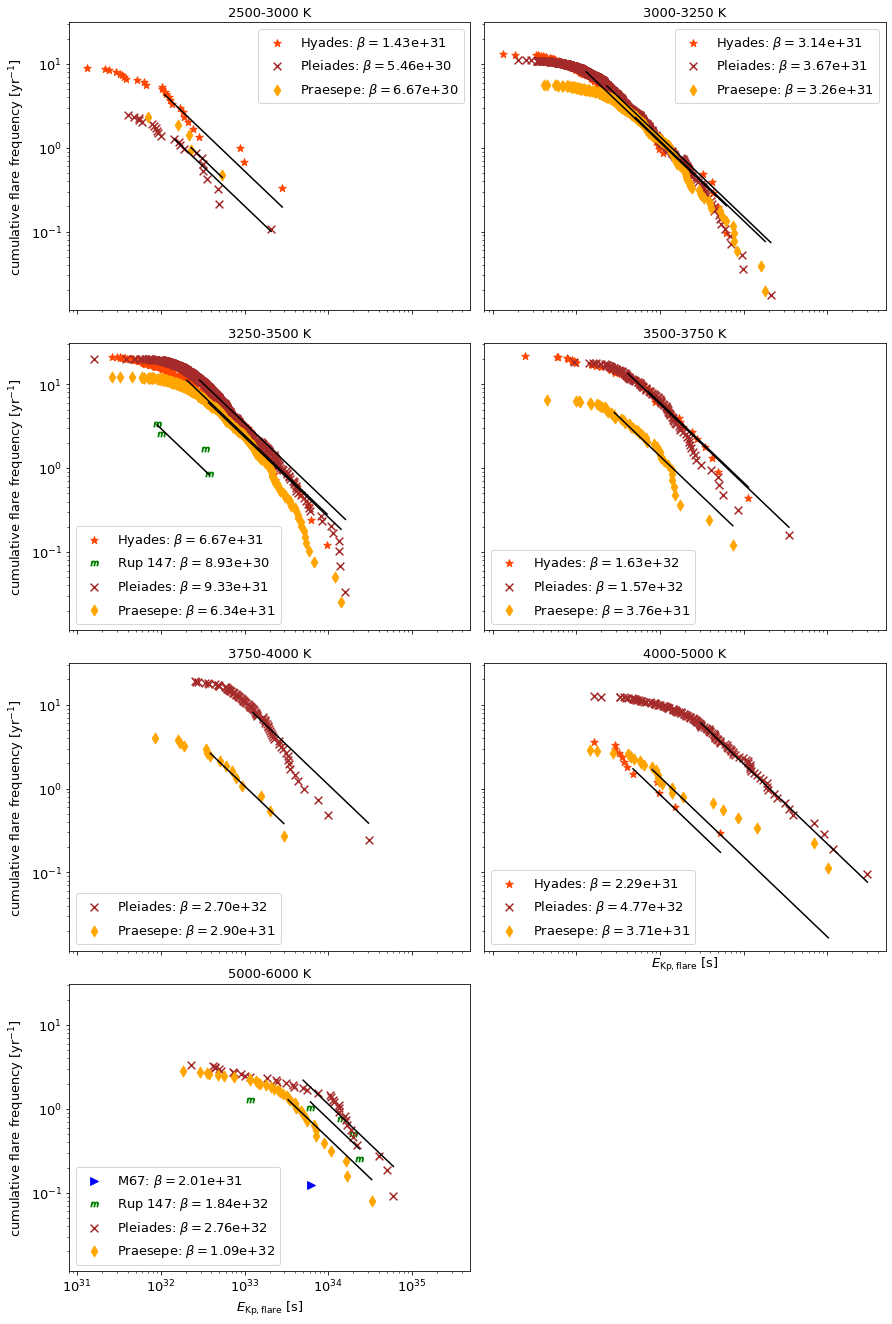

In [75]:


resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), sharex=True, sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df2.groupby(bins_T):
    resen[i]={}
    for j, h in g.groupby("cluster"):

      #  print(i,j)
      #  print(h.shape)
        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha, ffd.alpha_err = alpha, alpha_err

            betas, beta, beta_err = ffd.fit_beta_to_powerlaw(mode="energy")
            #print(f"Fitted power law beta={ffd.beta}")
            
            if j == "ngc2682":
                E, y = ffd.ed[0], ffd.freq[0]
                ffd.beta = y * np.power(E, ffd.alpha-1)
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
                
            else:
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resen[i][ccol[j][0]]={"beta_en":ffd.beta,
                                "beta_en_err":ffd.beta_err,
                                "nflares":len(ed),
                                "age":ccol[j][3],
                                "age_uperr":ccol[j][4],
                                "age_lowerr":ccol[j][5]
                                }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\beta=${ffd.beta:.2e}")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].legend()
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")
for i in [5,6]:
    axes[i].set_xlabel(r"$E_\mathrm{Kp,flare}$ [s]")
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy.png", dpi=300)

In [76]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta

,Teff,cluster,beta,beta_err,nflares,age,age_uperr,age_lowerr,beta_en,beta_en_err,Tmin,Tmax,Tmid,Tmid_err
0,2500-3000,Hyades,2671.111145,102.627829,27.0,690.0,160.0,100.0,1.426223e+31,5.502637e+29,2500,3000,2750,250
1,2500-3000,Pleiades,860.113973,36.658897,23.0,135.0,25.0,25.0,5.456846e+30,2.164438e+29,2500,3000,2750,250
2,2500-3000,Praesepe,784.146118,24.584268,5.0,750.0,3.0,7.0,6.674009e+30,4.437572e+29,2500,3000,2750,250
3,3000-3250,Hyades,1356.735220,43.953192,133.0,690.0,160.0,100.0,3.140244e+31,9.808266e+29,3000,3250,3125,125
4,3000-3250,Pleiades,1925.373192,58.775872,623.0,135.0,25.0,25.0,3.666010e+31,1.117962e+30,3000,3250,3125,125
5,3000-3250,Praesepe,1224.427570,37.611819,289.0,750.0,3.0,7.0,3.260052e+31,1.002064e+30,3000,3250,3125,125
6,3250-3500,Hyades,1046.076132,32.061320,175.0,690.0,160.0,100.0,6.667333e+31,2.054819e+30,3250,3500,3375,125
7,3250-3500,Rup 147,171.326355,15.656853,4.0,2650.0,380.0,380.0,8.934980e+30,8.165326e+29,3250,3500,3375,125
8,3250-3500,Pleiades,1712.719669,52.240664,597.0,135.0,25.0,25.0,9.334213e+31,2.851824e+30,3250,3500,3375,125
9,3250-3500,Praesepe,1053.998539,32.206654,477.0,750.0,3.0,7.0,6.338845e+31,1.938331e+30,3250,3500,3375,125


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


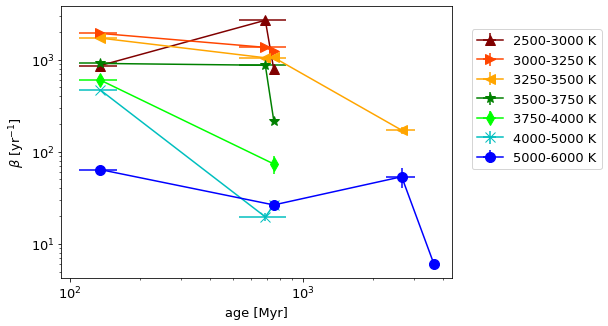

In [77]:
fig, ax = plt.subplots(figsize=(7,5))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
           label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
          marker=Tcols[str(label)][0],markersize=10)
ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc=(1.05,.4))

# Notes on very old clusters

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [ ]:

df[(df.cluster=="ngc6774") & (df.Teff_median > 3000.)].dropna(subset=["real"])[["dtp_tot", "EPIC","C","Teff_median", "ed_rec","note", "todrop"]]

In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).EPIC